# Analysis of Ovary Segmentation Baseline (Experiment 01)

### Summary
This notebook analyzes the performance of our initial baseline model, which was trained to segment ovaries from T2FS MRI scans. The primary goal of this experiment was to pivot from the previous uterus segmentation task to the correct ovary segmentation task and establish a quantitative and qualitative performance baseline. This gives us a benchmark to measure all future improvements against.

### Initial Analysis & Course Correction
Our first step was a critical review of the project's direction. We identified a major disconnect:
1.  **Problem**: The project was initially set up to segment the **uterus**, while the goal is to replicate the "RAovSeg" paper, which focuses on **ovary** segmentation.
2.  **Investigation**: We attempted to create a new data manifest for ovaries but discovered that the dataset is incomplete—not all patients have ovary masks. This is a common real-world data challenge.
3.  **Solution**: We performed a data audit by creating the `d2_data_audit.csv` file. This confirmed that **56 patients** met the paper's criteria of having both a T2FS MRI and a corresponding ovary mask. We then generated a clean manifest, `d2_manifest_t2fs_ovary_eligible.csv`, containing only these eligible patients.

### Baseline Methodology
The baseline experiment was run in the `07_ovary_baseline.ipynb` notebook with the following setup:
*   **Model**: Standard U-Net.
*   **Data**: 56 eligible patients from the D2_TCPW dataset, split into 44 for training and 12 for validation.
*   **Task**: Segmenting ovaries from T2FS MRI slices.
*   **Training**: The model was trained for 20 epochs using the Adam optimizer and a `DiceBCELoss`. We saved the model weights from the epoch with the highest validation Dice score.

### Results & Observations
1.  **Quantitative Performance**: The baseline performance is poor, confirming that ovary segmentation is a difficult task.
    *   The **best validation Dice score achieved was 0.4264 at epoch 3**.
    *   The validation loss and Dice curves show that the model begins to **overfit significantly after epoch 3**. The validation metrics become highly unstable while the training loss continues to decrease.

2.  **Qualitative Performance (Visual Analysis)**: The sample predictions below confirm the low Dice score.
    *   **Poor Localization**: The model correctly identifies the general region of the ovary but fails to produce a precise, well-defined mask.
    *   **High False Positives**: The model generates multiple disconnected blobs, indicating it is confused by surrounding tissues and noise. It struggles to distinguish the "what" from the "where".

### Conclusion & Next Steps
This baseline experiment was successful in establishing a clear performance benchmark (0.4264 Dice) on the correct task. The key failure mode identified is poor feature localization, leading to imprecise masks and false positives.

This provides a strong justification for our next step: implementing an **Attention U-Net**. This architecture is specifically designed to address poor localization by adding attention gates that help the model focus on the most relevant features and ignore noise, which is exactly the problem our baseline model is facing.

Successfully loaded model from ../models/07_ovary_baseline_best.pth
Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Loaded 64 validation slices.

Visualizing 5 sample predictions...


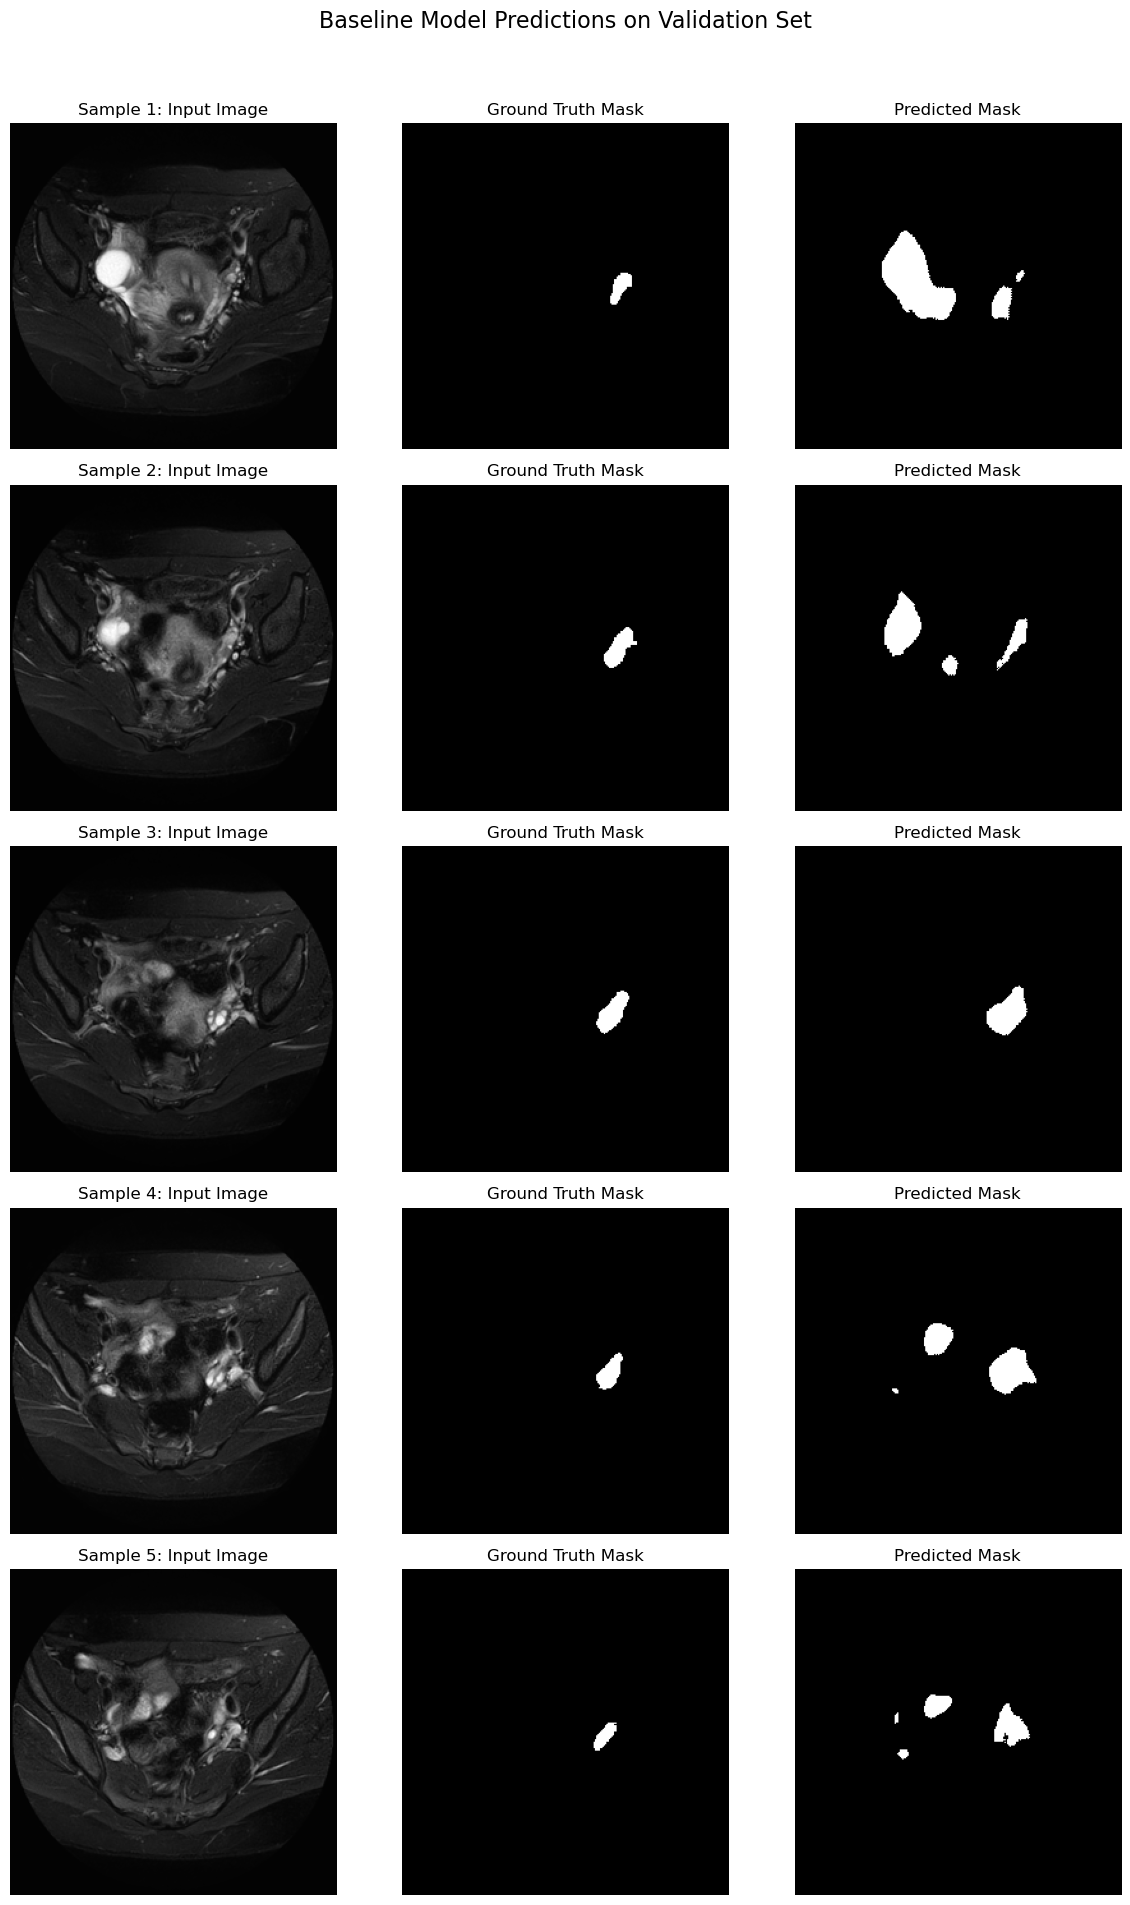

In [1]:
# --- Imports and Setup ---
import os
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np
from torch.utils.data import DataLoader, Subset

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDataset
from src.models import UNet

# --- Configuration ---
model_path = "../models/07_ovary_baseline_best.pth"
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
num_samples_to_show = 5 # How many examples to visualize

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1).to(device)

try:
    model.load_state_dict(torch.load(model_path))
    model.eval() # Set model to evaluation mode
    print(f"Successfully loaded model from {model_path}")
except FileNotFoundError:
    print(f"FATAL ERROR: Model file not found at {model_path}. Please make sure you have run the training in notebook 07 and the model was saved.")
    exit()

# --- Load Validation Data ---
# We only need the validation set to see how the model performs on unseen data.
# We create a new dataset instance that does NOT apply augmentations.
val_full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)

# Recreate the same validation split as in the training notebook
patient_ids = val_full_dataset.manifest['patient_id'].unique()
split_idx = int(len(patient_ids) * 0.8)
val_ids = patient_ids[split_idx:]
val_indices = [i for i, sm in enumerate(val_full_dataset.slice_map) if val_full_dataset.manifest.loc[sm['patient_index'], 'patient_id'] in val_ids]
val_dataset = Subset(val_full_dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) # Shuffle is False to get consistent results

print(f"Loaded {len(val_dataset)} validation slices.")

# --- Perform and Visualize Inference ---
print(f"\nVisualizing {num_samples_to_show} sample predictions...")

fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
fig.suptitle("Baseline Model Predictions on Validation Set", fontsize=16)

with torch.no_grad():
    # Loop through the first few samples of the validation loader
    for i, (image, mask) in enumerate(val_loader):
        if i >= num_samples_to_show:
            break
            
        image = image.to(device)
        
        # Get model output
        output = model(image)
        
        # Apply sigmoid and threshold to get a binary prediction mask
        pred_mask = torch.sigmoid(output) > 0.5
        
        # Move tensors to CPU and convert to numpy for plotting
        image_np = image.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_mask_np = pred_mask.cpu().squeeze().numpy()
        
        # Plot Original Image
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title(f"Sample {i+1}: Input Image")
        axes[i, 0].axis('off')
        
        # Plot Ground Truth Mask
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Plot Predicted Mask
        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()